<a href="https://colab.research.google.com/github/sedaoturak/dcgan_cahn-hilliard/blob/main/DCGAN_Cahn_Hillard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
try:
	from google.colab import drive
	IN_COLAB = True
	drive.mount('/content/drive')
	PATH = '/content/drive/MyDrive/Colab Notebooks/' # change this with your drive's path
except:
	IN_COLAB = False
	PATH = os.getcwd()[:-9]

Mounted at /content/drive


# Load data

In [4]:
# define the directory to dataset (the folder having the bitmap images and their strain energy values in text files
with open(PATH+'toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f:
  g = np.loadtxt(f)
with open(PATH+'toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

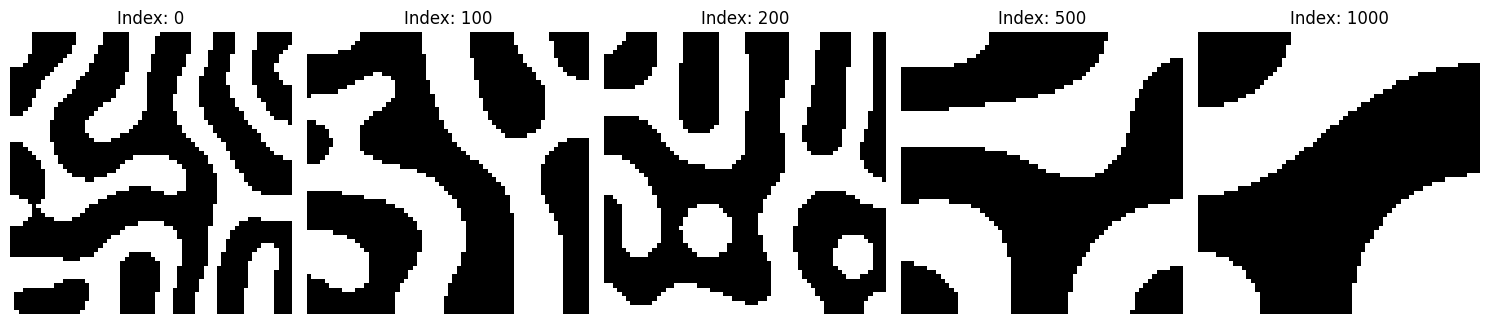

In [6]:
# visualize an image from dataset
img = g.reshape(37523,64,64) # reshape image dataset so that you'll get (number of images, first dimension, second dimension)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate([0, 100, 200, 500, 1000]): #random indices of five images
    axes[i].imshow(img[idx, :, :], interpolation='nearest', cmap='binary')
    axes[i].set_title(f"Index: {idx}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

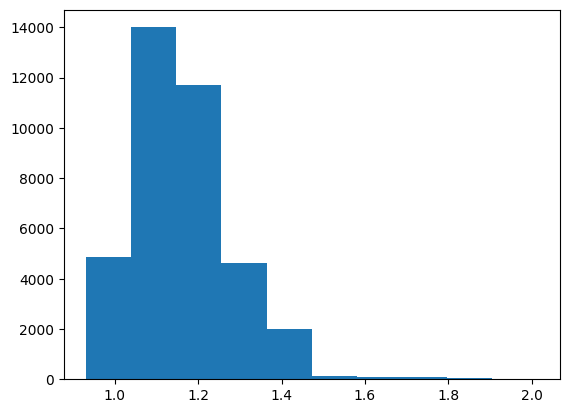

In [7]:
# visualize the distribution of the output (energy) values
# maximum energy (at the last index) is considered

fig, ax = plt.subplots()
ax.hist(e[:,-1])
plt.show()

In [8]:
# apply different preprocessing on the strain energy values to compare
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation
pt = PowerTransformer()
e_power = pt.fit_transform(e[:,-1].reshape(-1, 1))

# power transformation + normalization
scaler = MinMaxScaler(feature_range=(0,1))
e_power_scaled = scaler.fit_transform(e_power)

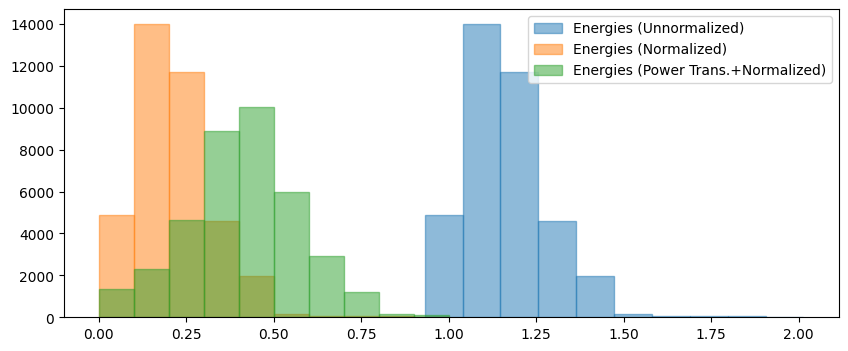

In [9]:
fig, axs = plt.subplots(figsize=(10,4))

axs.hist(e[:,-1], label=f'Energies (Unnormalized)', alpha=0.5, edgecolor='tab:blue', linewidth=1)
axs.hist(e_scaled, label=f'Energies (Normalized)', alpha=0.5, edgecolor='tab:orange', linewidth=1)
# axs.hist(e_power, label=f'Energies (Power Trans.)', alpha=0.5, edgecolor='tab:red', linewidth=1)
axs.hist(e_power_scaled, label=f'Energies (Power Trans.+Normalized)', alpha=0.5, edgecolor='tab:green', linewidth=1)
axs.legend()
plt.show()

In [10]:
# create Dataset class to define the dataset oject

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        # Normalize images to [-1, 1] for DCGAN Tanh output
        self.images = (torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 0.5) - 1.0
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

images = g.reshape((37523,64,64))
energies = e_power_scaled.ravel()

dataset = CustomDataset(images, energies)

# --- Updated: Train-Test Split ---
train_set_size = int(len(dataset) * 0.8)
val_set_size = len(dataset) - train_set_size
trainset, valset = random_split(dataset, [train_set_size, val_set_size])

batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


# Model

In [34]:
# Define the model
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 4, 4, 1, 0),      # 4x4
            # self._block(features_g * 16, features_g * 8, 4, 2, 1), # 8x8
            # self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),
            nn.Sigmoid(),
        )

    def _block(self, in_c, out_c, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

# Discriminator: Image -> Probability
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            # self._block(features_d * 2, features_d * 4, 4, 2, 1),
            # self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 2, 1, 4, 2, 0),
            nn.Sigmoid(),
        )

    def _block(self, in_c, out_c, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Training

In [37]:
# Initialize Models
device = "cuda" if torch.cuda.is_available() else "cpu"

gen = Generator(z_dim=64, channels_img=1, features_g=64).to(device)
disc = Discriminator(channels_img=1, features_d=64).to(device)
opt_gen = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = torch.nn.MSELoss(reduction='mean')

# Training loop
epochs = 50
train_loss_G, train_loss_D = [], []
val_loss_G, val_loss_D = [], []

for epoch in range(epochs):
    gen.train()
    disc.train()
    running_g_loss, running_d_loss = 0.0, 0.0

    # training
    for batch_idx, (real, _) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch} Training")):
        real = real.to(device)
        batch_curr = real.shape[0]
        noise = torch.randn(batch_curr, 64, 1, 1).to(device)
        fake = gen(noise)

        # train Discriminator
        disc_real = disc(real).view(-1)
        loss_d_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        loss_d_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_d_real + loss_d_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # train Generator
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        running_g_loss += loss_gen.item()
        running_d_loss += loss_disc.item()

    # validation
    disc.eval()
    gen.eval()
    running_val_d_loss = 0.0
    with torch.no_grad():
        for real, _ in valloader:
            real = real.to(device)
            batch_curr = real.shape[0]

            # Check how discriminator handles real validation images
            out_real = disc(real).view(-1)
            loss_v_real = criterion(out_real, torch.ones_like(out_real))

            # Check how discriminator handles fake images during validation
            noise = torch.randn(batch_curr, 64, 1, 1).to(device)
            fake = gen(noise)
            out_fake = disc(fake).view(-1)
            loss_v_fake = criterion(out_fake, torch.zeros_like(out_fake))

            running_val_d_loss += (loss_v_real + loss_v_fake).item() / 2

    # Save metrics
    train_loss_G.append(running_g_loss / len(trainloader))
    train_loss_D.append(running_d_loss / len(trainloader))
    val_loss_D.append(running_val_d_loss / len(valloader))

    print(f"Epoch {epoch}: G_Loss: {train_loss_G[-1]:.4f} | D_Loss: {train_loss_D[-1]:.4f} | Val_D_Loss: {val_loss_D[-1]:.4f}")

Epoch 0 Training: 100%|██████████| 470/470 [00:06<00:00, 78.22it/s]


Epoch 0: G_Loss: 0.9358 | D_Loss: 0.0067 | Val_D_Loss: 0.0573


Epoch 1 Training: 100%|██████████| 470/470 [00:05<00:00, 81.23it/s]


Epoch 1: G_Loss: 0.9840 | D_Loss: 0.0001 | Val_D_Loss: 0.0700


Epoch 2 Training: 100%|██████████| 470/470 [00:05<00:00, 79.30it/s]


Epoch 2: G_Loss: 0.9902 | D_Loss: 0.0000 | Val_D_Loss: 0.0775


Epoch 3 Training: 100%|██████████| 470/470 [00:05<00:00, 81.00it/s]


Epoch 3: G_Loss: 0.9931 | D_Loss: 0.0000 | Val_D_Loss: 0.0736


Epoch 4 Training: 100%|██████████| 470/470 [00:05<00:00, 79.45it/s]


Epoch 4: G_Loss: 0.9946 | D_Loss: 0.0000 | Val_D_Loss: 0.0751


Epoch 5 Training: 100%|██████████| 470/470 [00:05<00:00, 79.71it/s]


Epoch 5: G_Loss: 0.9957 | D_Loss: 0.0000 | Val_D_Loss: 0.0764


Epoch 6 Training: 100%|██████████| 470/470 [00:05<00:00, 79.91it/s]


Epoch 6: G_Loss: 0.9964 | D_Loss: 0.0000 | Val_D_Loss: 0.0776


Epoch 7 Training: 100%|██████████| 470/470 [00:06<00:00, 78.28it/s]


Epoch 7: G_Loss: 0.9969 | D_Loss: 0.0000 | Val_D_Loss: 0.0728


Epoch 8 Training: 100%|██████████| 470/470 [00:05<00:00, 81.83it/s]


Epoch 8: G_Loss: 0.9974 | D_Loss: 0.0000 | Val_D_Loss: 0.0847


Epoch 9 Training: 100%|██████████| 470/470 [00:09<00:00, 51.98it/s]


Epoch 9: G_Loss: 0.9978 | D_Loss: 0.0000 | Val_D_Loss: 0.0755


Epoch 10 Training: 100%|██████████| 470/470 [00:05<00:00, 81.34it/s]


Epoch 10: G_Loss: 0.9981 | D_Loss: 0.0000 | Val_D_Loss: 0.0750


Epoch 11 Training: 100%|██████████| 470/470 [00:06<00:00, 76.03it/s]


Epoch 11: G_Loss: 0.9983 | D_Loss: 0.0000 | Val_D_Loss: 0.0748


Epoch 12 Training: 100%|██████████| 470/470 [00:05<00:00, 80.97it/s]


Epoch 12: G_Loss: 0.9986 | D_Loss: 0.0000 | Val_D_Loss: 0.0859


Epoch 13 Training: 100%|██████████| 470/470 [00:06<00:00, 76.04it/s]


Epoch 13: G_Loss: 0.9988 | D_Loss: 0.0000 | Val_D_Loss: 0.0770


Epoch 14 Training: 100%|██████████| 470/470 [00:05<00:00, 80.23it/s]


Epoch 14: G_Loss: 0.9989 | D_Loss: 0.0000 | Val_D_Loss: 0.0794


Epoch 15 Training: 100%|██████████| 470/470 [00:06<00:00, 76.31it/s]


Epoch 15: G_Loss: 0.9990 | D_Loss: 0.0000 | Val_D_Loss: 0.0841


Epoch 16 Training: 100%|██████████| 470/470 [00:05<00:00, 80.36it/s]


Epoch 16: G_Loss: 0.9992 | D_Loss: 0.0000 | Val_D_Loss: 0.0701


Epoch 17 Training: 100%|██████████| 470/470 [00:06<00:00, 76.30it/s]


Epoch 17: G_Loss: 0.9993 | D_Loss: 0.0000 | Val_D_Loss: 0.0751


Epoch 18 Training: 100%|██████████| 470/470 [00:06<00:00, 77.43it/s]


Epoch 18: G_Loss: 0.9994 | D_Loss: 0.0000 | Val_D_Loss: 0.0716


Epoch 19 Training: 100%|██████████| 470/470 [00:06<00:00, 77.12it/s]


Epoch 19: G_Loss: 0.9994 | D_Loss: 0.0000 | Val_D_Loss: 0.0629


Epoch 20 Training: 100%|██████████| 470/470 [00:06<00:00, 76.95it/s]


Epoch 20: G_Loss: 0.9995 | D_Loss: 0.0000 | Val_D_Loss: 0.0623


Epoch 21 Training: 100%|██████████| 470/470 [00:05<00:00, 78.72it/s]


Epoch 21: G_Loss: 0.9996 | D_Loss: 0.0000 | Val_D_Loss: 0.1076


Epoch 22 Training: 100%|██████████| 470/470 [00:06<00:00, 76.18it/s]


Epoch 22: G_Loss: 0.9997 | D_Loss: 0.0000 | Val_D_Loss: 0.0719


Epoch 23 Training: 100%|██████████| 470/470 [00:05<00:00, 79.49it/s]


Epoch 23: G_Loss: 0.9997 | D_Loss: 0.0000 | Val_D_Loss: 0.0834


Epoch 24 Training: 100%|██████████| 470/470 [00:06<00:00, 68.65it/s]


Epoch 24: G_Loss: 0.9997 | D_Loss: 0.0000 | Val_D_Loss: 0.0788


Epoch 25 Training: 100%|██████████| 470/470 [00:05<00:00, 79.60it/s]


Epoch 25: G_Loss: 0.9997 | D_Loss: 0.0000 | Val_D_Loss: 0.0831


Epoch 26 Training: 100%|██████████| 470/470 [00:06<00:00, 70.88it/s]


Epoch 26: G_Loss: 0.9998 | D_Loss: 0.0000 | Val_D_Loss: 0.0806


Epoch 27 Training: 100%|██████████| 470/470 [00:05<00:00, 78.85it/s]


Epoch 27: G_Loss: 0.9998 | D_Loss: 0.0000 | Val_D_Loss: 0.1052


Epoch 28 Training: 100%|██████████| 470/470 [00:06<00:00, 75.65it/s]


Epoch 28: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.0931


Epoch 29 Training: 100%|██████████| 470/470 [00:05<00:00, 79.06it/s]


Epoch 29: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.1128


Epoch 30 Training: 100%|██████████| 470/470 [00:06<00:00, 75.08it/s]


Epoch 30: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.1075


Epoch 31 Training: 100%|██████████| 470/470 [00:05<00:00, 78.96it/s]


Epoch 31: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.0874


Epoch 32 Training: 100%|██████████| 470/470 [00:06<00:00, 74.16it/s]


Epoch 32: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.1037


Epoch 33 Training: 100%|██████████| 470/470 [00:06<00:00, 78.15it/s]


Epoch 33: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.0958


Epoch 34 Training: 100%|██████████| 470/470 [00:06<00:00, 74.68it/s]


Epoch 34: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.0809


Epoch 35 Training: 100%|██████████| 470/470 [00:06<00:00, 75.92it/s]


Epoch 35: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.1150


Epoch 36 Training: 100%|██████████| 470/470 [00:06<00:00, 76.31it/s]


Epoch 36: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.1110


Epoch 37 Training: 100%|██████████| 470/470 [00:06<00:00, 75.83it/s]


Epoch 37: G_Loss: 0.9999 | D_Loss: 0.0000 | Val_D_Loss: 0.1231


Epoch 38 Training: 100%|██████████| 470/470 [00:05<00:00, 78.68it/s]


Epoch 38: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1234


Epoch 39 Training: 100%|██████████| 470/470 [00:06<00:00, 73.69it/s]


Epoch 39: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1376


Epoch 40 Training: 100%|██████████| 470/470 [00:06<00:00, 78.29it/s]


Epoch 40: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1347


Epoch 41 Training: 100%|██████████| 470/470 [00:06<00:00, 75.02it/s]


Epoch 41: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1425


Epoch 42 Training: 100%|██████████| 470/470 [00:06<00:00, 78.32it/s]


Epoch 42: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1365


Epoch 43 Training: 100%|██████████| 470/470 [00:06<00:00, 74.96it/s]


Epoch 43: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.0893


Epoch 44 Training: 100%|██████████| 470/470 [00:06<00:00, 77.70it/s]


Epoch 44: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1246


Epoch 45 Training: 100%|██████████| 470/470 [00:06<00:00, 74.93it/s]


Epoch 45: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1287


Epoch 46 Training: 100%|██████████| 470/470 [00:06<00:00, 78.28it/s]


Epoch 46: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1402


Epoch 47 Training: 100%|██████████| 470/470 [00:06<00:00, 74.67it/s]


Epoch 47: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1527


Epoch 48 Training: 100%|██████████| 470/470 [00:05<00:00, 78.48it/s]


Epoch 48: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1315


Epoch 49 Training: 100%|██████████| 470/470 [00:06<00:00, 74.03it/s]


Epoch 49: G_Loss: 1.0000 | D_Loss: 0.0000 | Val_D_Loss: 0.1484


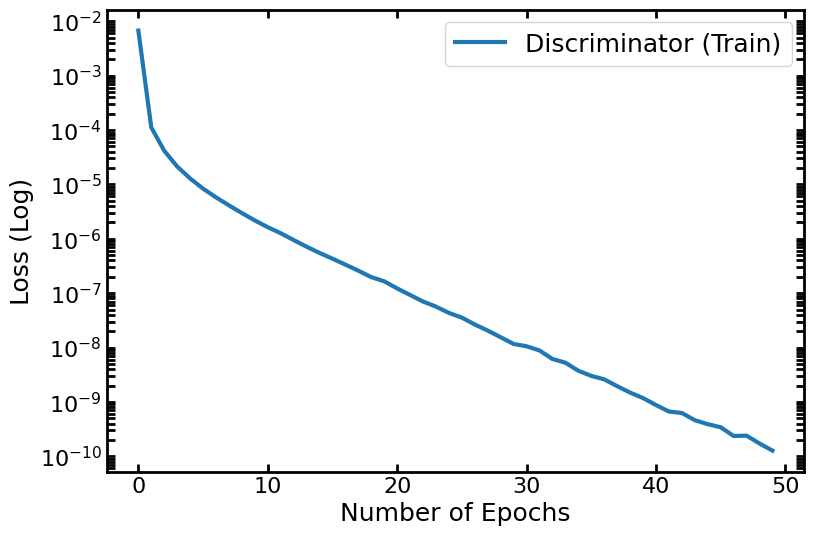

In [41]:
fig, ax = plt.subplots(figsize=(9, 6))
font_size, ticklabel_size = 18, 16

ax.plot(train_loss_D, '-', label='Discriminator (Train)', linewidth=3)
# ax.plot(train_loss_G,'--', label='Generator (Train)', linewidth=3)

ax.set_ylabel('Loss (Log)', fontsize=font_size)
ax.set_xlabel('Number of Epochs', fontsize=font_size)
ax.set_yscale('log')

ax.xaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.yaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.tick_params(which='both', width=2, length=6, top=True, right=True, direction='in')
plt.setp(ax.spines.values(), linewidth=2)
ax.legend(fontsize=font_size)
plt.show()

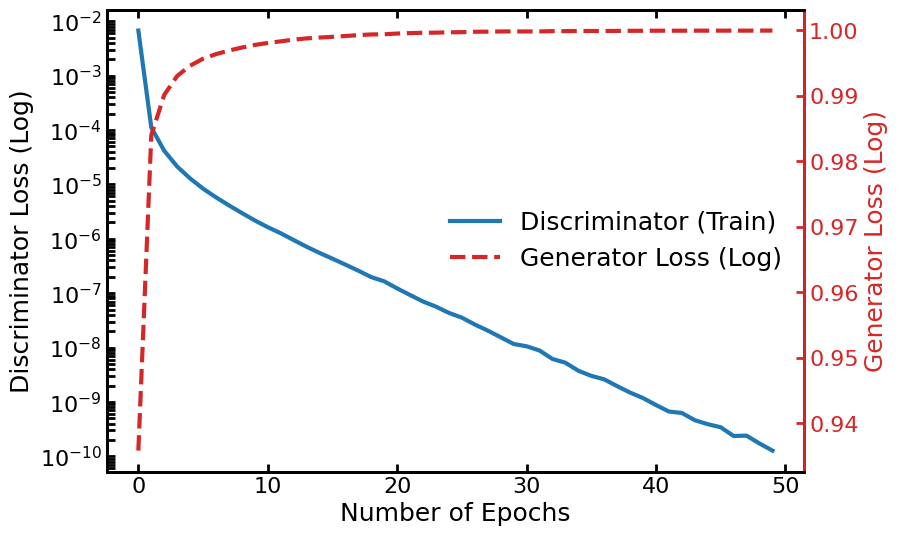

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))
font_size, ticklabel_size = 18, 16

# Primary (left) axis
color_d = 'tab:blue'
l1 = ax.plot(train_loss_D, '-', label='Discriminator (Train)', linewidth=3, color=color_d)

ax.set_ylabel('Discriminator Loss (Log)', fontsize=font_size)
ax.set_xlabel('Number of Epochs', fontsize=font_size)
ax.set_yscale('log')

ax.xaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.yaxis.set_tick_params(width=2, length=5, labelsize=ticklabel_size)
ax.tick_params(which='both', width=2, length=6, top=True, right=True, direction='in')
plt.setp(ax.spines.values(), linewidth=2)


ax2 = ax.twinx()
color_g = 'tab:red'
l2 = ax2.plot(train_loss_G, '--', label='Generator Loss (Log)', linewidth=3, color=color_g)
ax2.tick_params(axis='y', colors=color_g, width=2, length=6, direction='in')
ax2.yaxis.label.set_color(color_g)
ax2.spines['right'].set_color(color_g)
ax2.yaxis.set_tick_params(labelsize=ticklabel_size)
ax2.set_ylabel('Generator Loss (Log)', fontsize=font_size, color=color_g)
plt.setp(ax2.spines.values(), linewidth=2)

# Legend
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize=font_size, loc='center right', frameon=False)
plt.show()

In [ ]:
# save model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
torch.save(model, os.path.join(PATH, f'mech_MNIST_entire.pt'))

# model_scripted = torch.jit.script(model.cpu())
# model_scripted.save(os.path.join(PATH, f'mech_MNIST_scripted.pt'))

In [ ]:
# load trained model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
model = torch.load(os.path.join(PATH, f'mech_MNIST_entire.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reconstructed Images

In [42]:
original_images = []
reconstructed_images = []
z_train = np.zeros((0,16))
idx_train = []
strain_energy = np.zeros((0,1))
for i, (d,t) in tqdm(enumerate(trainloader)):
  d = d.to(device)
  t = t.to(device)
  z, _, _, out = gen(d,t)
  original_images.append(d.cpu().detach().numpy())
  reconstructed_images.append(out.cpu().detach().numpy())
  z_train = np.vstack([z_train,z.cpu().detach().numpy()])
  strain_energy = np.vstack([strain_energy, t.cpu().detach().numpy()])
strain_energy = strain_energy.ravel()

0it [00:00, ?it/s]


TypeError: Generator.forward() takes 2 positional arguments but 3 were given